**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [33]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neighbors import KDTree
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearnz

In [48]:
%%pycodestyle
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import pdist, squareform

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.X = np.array([])
        self.y = np.array([])
        self.pp = 0
          
    def fit(self, X, y):
        # remember training set or build a tree
        self.X = X
        self.y = y
        if (self.algorithm == 'kd_tree'):
            self.KDTree = KDTree(self.X)
            
    def predict(self, X):
        n_classes = np.unique(self.y).shape[0]
        k = self.n_neighbors
        
        if (self.algorithm == 'brute'):
            dist = pairwise_distances(X, self.X, metric=self.metric)
            kneighbours_idx = np.argpartition(dist, k, axis=1)[:, :k]

        elif (self.algorithm == 'kd_tree'):
            kneighbours_idx = self.KDTree.query(X, k, return_distance=False)

        classes = self.y[kneighbours_idx]
        votes = np.apply_along_axis(lambda x: np.bincount(x, minlength=n_classes), axis=1, arr=classes)
        self.pp = votes
        return np.argmax(votes, axis=1)

    def tune_k(self, n_splits=3):
        kfolds = KFold(n_splits=n_splits)
        max_k = 20
        res = []
        for k in range(1, max_k + 1):
            scores = []
            knn = MyKNeighborsClassifier(k, self.algorithm, self.metric)
            for train_index, test_index in kfolds.split(self.X):
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]
            
                knn.fit(X_train, y_train)        
                scores.append(knn.score(X_test, y_test))
            res.append(np.mean(np.asarray(scores)))
        return np.argmax(np.asarray(res))
        
    def predict_proba(self, X):
        return self.pp/self.n_neighbors
    
    def score(self, X, y):
        res = self.predict(X) == y.astype(np.int32)
        return np.average(res)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [49]:
iris = datasets.load_iris()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [52]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [53]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [54]:
#X_train.shape
my_clf.predict(np.asarray([[3,1,2,44]]))

array([2])

In [55]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [56]:
%time clf.fit(X_train, y_train)

CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 1.19 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [57]:
%time my_clf.fit(X_train, y_train)

CPU times: user 17 µs, sys: 1e+03 ns, total: 18 µs
Wall time: 27.4 µs


In [58]:
%time clf.predict(X_test)

CPU times: user 5.51 ms, sys: 16 µs, total: 5.52 ms
Wall time: 24.4 ms


array([1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2])

In [59]:
%time my_clf.predict(X_test)

CPU times: user 1.48 ms, sys: 0 ns, total: 1.48 ms
Wall time: 1.5 ms


array([1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2])

In [60]:
%time clf.predict_proba(X_test)

CPU times: user 3.18 ms, sys: 59 µs, total: 3.23 ms
Wall time: 9.94 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [61]:
%time my_clf.predict_proba(X_test)

CPU times: user 96 µs, sys: 0 ns, total: 96 µs
Wall time: 385 µs


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [62]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [63]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [64]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 3.58 ms, total: 3.58 ms
Wall time: 14 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [65]:
%time my_clf.fit(X_train, y_train)

CPU times: user 275 µs, sys: 0 ns, total: 275 µs
Wall time: 273 µs


In [66]:
%time clf.predict(X_test)

CPU times: user 2.89 ms, sys: 0 ns, total: 2.89 ms
Wall time: 3.34 ms


array([0, 1, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0])

In [67]:
%time my_clf.predict(X_test)

CPU times: user 2.09 ms, sys: 47 µs, total: 2.14 ms
Wall time: 8.64 ms


array([0, 1, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0])

In [68]:
%time clf.predict_proba(X_test)

CPU times: user 1.47 ms, sys: 155 µs, total: 1.62 ms
Wall time: 1.63 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ]])

In [69]:
%time my_clf.predict_proba(X_test)

CPU times: user 61 µs, sys: 7 µs, total: 68 µs
Wall time: 75.8 µs


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ]])

In [70]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [71]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [72]:
data = newsgroups['data']
target = newsgroups['target']
newsgroups.target_names
#newsgroups['sci.electronics']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [73]:
data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [74]:
import re
data_lower = [x.lower() for x in data]
print(data_lower[0])
data_replaced = [re.sub('[^a-z0-9]', ' ', x) for x in data_lower]
data_tok_splitted = [[w for w in x.split(' ') if w != ''] for x in data_replaced] #realize here

data_tok = []
targets_tok = []
for d, t in zip(data_tok_splitted, target):
    if len(d) != 0:
        data_tok.append(d)
        targets_tok.append(t)
# data_tok should be a list of lists of tokens for each line in data.

i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 60s/
early 70s. it was called a bricklin. the doors were really small. in addition,
the front bumper was separate from the rest of the body. this is 
all i know. if anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [75]:
print(len(targets_tok), len(data_tok))

11004 11004


In [76]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [77]:
from scipy.sparse import csr_matrix, lil_matrix
import itertools

# 1й проход - ищем уникальные слова
result_words_set = set([w for w in itertools.chain(*data_tok)])
result_words = dict()
for w_id, w in enumerate(result_words_set):
    result_words[w] = w_id

In [78]:
from collections import Counter

result = lil_matrix((len(data_tok), len(result_words)), dtype=int)
for text_id, text in enumerate(data_tok):
    for w, w_count in Counter(text).items():
        result[text_id, result_words[w]] = w_count

In [615]:
result_csr = result.tocsr()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [617]:
result_csr.shape

(11004, 98734)

In [618]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=3)
y = np.asarray(targets_tok)

for train_index, test_index in kfolds.split(result_csr):
    X_train, X_test = result_csr[train_index], result_csr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#X_train.shape
#y_train.shape
#result_csr.shape
#targets = np.asarray(targets_tok)
    #y_train, y_test = y[train_index], y[test_index]
#for train_idx, test_idx in kfolds.split(result_csr):
#    print(len(train_idx), len(test_idx))
#    print(train_idx[:10], test_idx[:10])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [376]:
#def get_accuracy(csr_matrix, targets, train_idx, test_idx, n_neighbours):
#    train = csr_matrix[train_idx]
    #train_idx = //
#    print(train.shape, test.shape)

#for train_idx, test_idx in kfolds.split(result_csr):
#    get_accuracy(result_csr, targets_tok, train_idx, test_idx, 5)

In [444]:
def get_k():
    #knn = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')    
    kfolds = KFold(n_splits=3)
    avg = []
    
    for k in range(1, 11):
        knn = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
        scores = []
        for train_index, test_index in kfolds.split(result_csr):
            X_train, X_test = result_csr[train_index], result_csr[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            knn.fit(X_train, y_train)
        
            scores.append(knn.score(X_test, y_test))
        avg.append(np.mean(np.asarray(scores)))
        #print(avg)
    return np.argmax(np.asarray(avg))

In [460]:
def get_score(k, n_splits=3):
    #knn = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')    
    kfolds = KFold(n_splits=n_splits)
    knn = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = []
    for train_index, test_index in kfolds.split(result_csr):
        X_train, X_test = result_csr[train_index], result_csr[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)        
        scores.append(knn.score(X_test, y_test))
    return np.mean(np.asarray(scores))

scores = [get_score(i) for i in range(1,11)]
scores

[0.21646673936750271,
 0.19302071973827703,
 0.18738640494365688,
 0.1933842239185751,
 0.19683751363140675,
 0.19810977826245002,
 0.19865503453289712,
 0.20147219193020718,
 0.20519810977826244,
 0.2063794983642312]

Text(0, 0.5, 'accuracy')

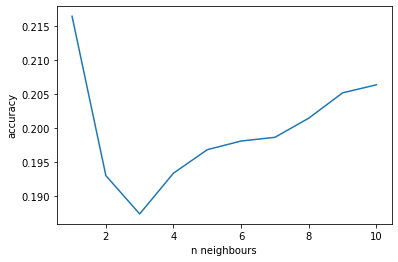

In [467]:
plt.plot(np.arange(1,11), scores);
plt.xlabel('n neighbours')
plt.ylabel('accuracy')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [599]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf = TfidfTransformer()

In [581]:
def cos_k(k):
    kfolds = KFold(n_splits=3)
    knn = MyKNeighborsClassifier(n_neighbors=k, metric='cosine') 
    scores = []
    for train_index, test_index in kfolds.split(result_csr):
        X_train, X_test = result_csr[train_index], result_csr[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)        
        scores.append(knn.score(X_test, y_test))
    return np.mean(np.asarray(scores))

scores_cos = [cos_k(i) for i in range(1,11)]
scores_cos

[0.2878044347509996,
 0.2727190112686296,
 0.27162849872773537,
 0.26472191930207195,
 0.2604507451835696,
 0.25863322428207924,
 0.25854234823700467,
 0.2615412577244638,
 0.25817884405670666,
 0.25854234823700467]

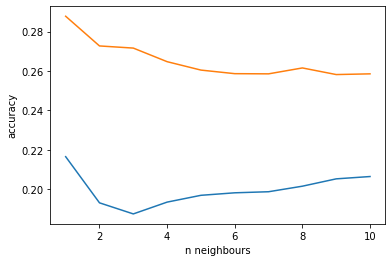

In [597]:
plt.plot(np.arange(1,11), scores);
plt.xlabel('n neighbours')
plt.ylabel('accuracy')
plt.plot(np.arange(1,11), scores_cos);

In [621]:
X_train = result_csr
y_train = np.asarray(targets_tok)

model = MyKNeighborsClassifier(n_neighbors=1, metric='cosine')
model.fit(X_train, y_train)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [622]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [627]:
def transform(newsgroups):
    data = newsgroups['data']
    target = newsgroups['target']
    #newsgroups.target_names
    data_lower = [x.lower() for x in data]
    data_replaced = [re.sub('[^a-z0-9]', ' ', x) for x in data_lower]
    data_tok_splitted = [[w for w in x.split(' ') if w != ''] for x in data_replaced] #realize here

    data_tok = []
    targets_tok = []
    for d, t in zip(data_tok_splitted, target):
        if len(d) != 0:
            data_tok.append(d)
            targets_tok.append(t)
            
    result_words_set = set([w for w in itertools.chain(*data_tok)])
    result_words = dict()
    for w_id, w in enumerate(result_words_set):
        result_words[w] = w_id
        
    result = lil_matrix((len(data_tok), len(result_words)), dtype=int)
    for text_id, text in enumerate(data_tok):
        for w, w_count in Counter(text).items():
            result[text_id, result_words[w]] = w_count
    return result.tocsr(), np.asarray(targets_tok)

X_test, y_test = transform(newsgroups)